# Загрузите обучающий и тестовый набор данных

In [ ]:
import pandas as pd

train = pd.read_parquet('0000.parquet', engine='pyarrow')[:2000]
test = pd.read_parquet('0000 (1).parquet', engine='pyarrow')[:2000]

train = train.drop(columns=['summary', 'url', 'title', 'date'])
test = test.drop(columns=['summary', 'url', 'title', 'date'])

train

,text,topic
0,Сладострастник в течение трех лет преследовал ...,incident
1,Буквально за час до боя курантов в подземном п...,incident
2,"Там они покатались на лыжах и снегоходах, пооб...",politics
3,Сосед расстрелял соседа из-за претензий по пов...,incident
4,Причиной трагедии специалисты считают нарушени...,incident
...,...,...
1995,"Скачка закончилась, а безусловный победитель т...",politics
1996,.Сводный оркестр — поистине белая кость военно...,politics
1997,Эту горькую правду знает весь Междуреченск. Зд...,incident
1998,8 мая президент Медведев поставил свою подпись...,politics


# Выполните предварительную обработку обучающей и тестирующей выборки, преобразуйте обе коллекции документов.

In [ ]:
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def preprocess(text: str) -> str:
    pattern = re.compile(r'[^а-я]+')
    text = text.lower()
    text = pattern.sub(' ', text).strip()

    word_list = word_tokenize(text)
    stopwords_list = set(stopwords.words('russian'))

    word_list = [word for word in word_list if word not in stopwords_list]
    word_list = [word for word in word_list if len(word) > 2]
    word_list = [word for word in word_list if word not in string.punctuation]

    lemma = WordNetLemmatizer()
    word_list = [lemma.lemmatize(word) for word in word_list]
    text= ' '.join(word_list)

    return text

In [ ]:
train['text'] = train['text'].apply(lambda x: preprocess(x))
test['text'] = test['text'].apply(lambda x: preprocess(x))

In [ ]:
train

,text,topic
0,сладострастник течение трех лет преследовал по...,incident
1,буквально час боя курантов подземном переходе ...,incident
2,покатались лыжах снегоходах пообщались другими...,politics
3,сосед расстрелял соседа претензий поводу затоп...,incident
4,причиной трагедии специалисты считают нарушени...,incident
...,...,...
1995,скачка закончилась безусловный победитель выяв...,politics
1996,сводный оркестр поистине белая кость военной д...,politics
1997,горькую правду знает весь междуреченск вообще ...,incident
1998,мая президент медведев поставил подпись законо...,politics


# Выполните векторизацию с использованием CountVectorizer и получите документы в виде “мешков слов”.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
!pip install bigartm
from artm import BatchVectorizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.8 MB/s eta 0:00:00


In [ ]:
vectorizer_train = CountVectorizer(ngram_range=(1,3), max_features=20000)
vectorizer_test = CountVectorizer(ngram_range=(1,3), max_features=20000)
m_train = vectorizer_train.fit_transform(train['text'])
m_test = vectorizer_test.fit_transform(test['text'])

m_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
m_train.toarray().shape

(2000, 20000)

In [ ]:
n_wd_train = m_train.todense().T
n_wd_test = m_test.todense().T

In [ ]:
n_wd_train.shape

(20000, 2000)

In [ ]:
vocabulary_train = vectorizer_train.get_feature_names_out()
vocabulary_test = vectorizer_test.get_feature_names_out()

vocabulary_train

array(['абрамович', 'абсолютно', 'абсолютно уверен', ..., 'ясно',
       'ячейки', 'ящик'], dtype=object)

In [ ]:
batch_vectorizer_train = BatchVectorizer(data_format='bow_n_wd', n_wd=n_wd_train, vocabulary=vocabulary_train, target_folder='batches1')
batch_vectorizer_test = BatchVectorizer(data_format='bow_n_wd', n_wd=n_wd_test, vocabulary=vocabulary_test, target_folder='batches2')

/usr/local/lib/python3.10/dist-packages/artm/batches_utils.py:227: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix


#Обучите модель LDA с использованием библиотеки BigARTM. С помощью matplotlib постройте график изменения перплексии в ходе обучения.

In [ ]:
import matplotlib.pyplot as plt
def paint(list_):
    plt.plot(list(range(len(list_))), list_)
    plt.show()

In [ ]:
import artm

dictionary = batch_vectorizer_train.dictionary

In [ ]:
lda = artm.LDA(num_topics=16, alpha=0.1, beta=0.1, num_document_passes=5, dictionary=batch_vectorizer_train.dictionary)

In [ ]:
lda.fit_offline(batch_vectorizer_train, num_collection_passes=10)

In [ ]:
lda.phi_

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15
августа,0.000105,0.000048,0.000004,0.000043,0.000003,0.000004,0.000053,0.000003,0.000078,0.000092,0.000081,0.000014,0.000142,0.000174,0.000199,0.000043
августа года,0.000098,0.000054,0.000004,0.000008,0.000003,0.000004,0.000059,0.000004,0.000120,0.000036,0.000085,0.000024,0.000059,0.000058,0.000053,0.000040
бабушке,0.000005,0.000004,0.000008,0.000005,0.000003,0.000005,0.000004,0.000003,0.000004,0.000053,0.000005,0.000003,0.000032,0.000112,0.000005,0.000003
берегу,0.000005,0.000098,0.000105,0.000011,0.000435,0.000004,0.000004,0.000004,0.000013,0.000064,0.000009,0.000021,0.000005,0.000271,0.000009,0.000007
быстрого,0.000018,0.000005,0.000029,0.000005,0.000004,0.000060,0.000039,0.000018,0.000004,0.000040,0.000004,0.000003,0.000005,0.000002,0.000049,0.000036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
дальность,0.000005,0.000005,0.000003,0.000005,0.000003,0.000004,0.000004,0.000003,0.000004,0.000002,0.000004,0.000295,0.000005,0.000002,0.000004,0.000003
дальность стрельбы,0.000005,0.000005,0.000003,0.000005,0.000003,0.000004,0.000004,0.000003,0.000004,0.000002,0.000004,0.000237,0.000005,0.000002,0.000004,0.000003
запас хода,0.000005,0.000005,0.000003,0.000005,0.000003,0.000004,0.000004,0.000003,0.000004,0.000002,0.000004,0.000207,0.000005,0.000002,0.000004,0.000003
масса тонны,0.000005,0.000005,0.000003,0.000005,0.000003,0.000004,0.000004,0.000003,0.000004,0.000002,0.000004,0.000149,0.000005,0.000002,0.000004,0.000003


In [ ]:
lda.phi_['topic_12'].nlargest(n=10)

года              0.007496
это               0.004833
суд               0.004445
также             0.004200
области           0.004138
известно          0.003279
человек           0.003272
стало             0.003263
стало известно    0.003221
году              0.003099
Name: topic_12, dtype: float32

In [ ]:
lda.phi_['topic_13'].nlargest(n=10)

это        0.013224
очень      0.007149
время      0.004710
лет        0.003471
жизни      0.003401
день       0.003002
нам        0.002964
говорит    0.002742
человек    0.002474
район      0.002391
Name: topic_13, dtype: float32

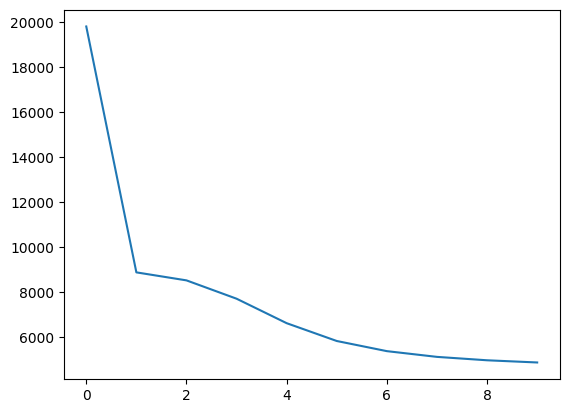

In [ ]:
paint(lda.perplexity_value)

#Попробуйте несколько вариантов значений параметра “количество тем” (минимум 3 варианта).

In [ ]:
lda = artm.LDA(num_topics=5, alpha=0.1, beta=0.1, num_document_passes=5, dictionary=batch_vectorizer_train.dictionary)

lda.fit_offline(batch_vectorizer_train, num_collection_passes=10)

lda.perplexity_value[-1]

6426.60546875

In [ ]:
lda = artm.LDA(num_topics=10, alpha=0.1, beta=0.1, num_document_passes=5, dictionary=batch_vectorizer_train.dictionary)

lda.fit_offline(batch_vectorizer_train, num_collection_passes=10)

lda.perplexity_value[-1]

5441.73046875

In [ ]:
lda = artm.LDA(num_topics=15, alpha=0.1, beta=0.1, num_document_passes=5, dictionary=batch_vectorizer_train.dictionary)

lda.fit_offline(batch_vectorizer_train, num_collection_passes=10)

lda.perplexity_value[-1]

4939.953125

#Не меняя других параметров модели подберите оптимальное количество тем (с помощью перплексии).

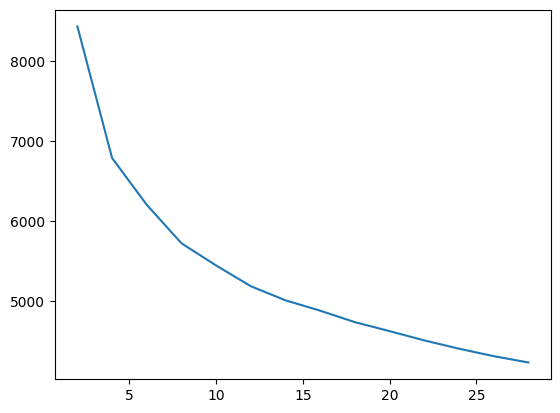

In [ ]:
list_perplexity = []
for i in range(2, 30, 2):
    lda = artm.LDA(num_topics=i, alpha=0.1, beta=0.1, num_document_passes=5, dictionary=batch_vectorizer_train.dictionary)
    lda.fit_offline(batch_vectorizer_train, num_collection_passes=10)
    list_perplexity.append(lda.perplexity_last_value)

plt.plot(list(range(2, 30, 2)), list_perplexity)
plt.show()

#Обучите модель общего вида, добавьте несколько регуляризаторов (минимум один). Постройте график изменения перплексии в ходе обучения.

Добавим регуляризатор для разреживания матрицы  Φ .Регуляризатор DecorrelatorPhiRegularizer позволяет усилить различие между темами.

In [ ]:
model = artm.ARTM(num_topics=10, dictionary=batch_vectorizer_train.dictionary, num_document_passes = 3, cache_theta= True)

model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='smooth_sparse_phi_regularizer', tau=-4))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(tau=5e5))

model.scores.add(artm.PerplexityScore(name='perplexity_score')) # перплексия
model.scores.add(artm.TopTokensScore(name='top_tokens_score')) # топовые темы

model.fit_offline(batch_vectorizer_train, num_collection_passes=5)


#paint(model.score_tracker['perplexity_score'].value)
model.get_score('perplexity_score').value

1091.1695556640625

#Определите темы документов тестовой выборки и расчитайте перплексию для нее.

In [ ]:
answers = model.transform(batch_vectorizer_test).transpose()

answers

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.147567,0.101044,0.071601,0.065534,0.074834,0.118152,0.083506,0.085494,0.211725,0.040544
1,0.077662,0.143386,0.023876,0.057940,0.057666,0.242630,0.082529,0.091479,0.119887,0.102943
2,0.068552,0.044769,0.114020,0.084286,0.194271,0.126740,0.035671,0.074693,0.179507,0.077491
3,0.111716,0.098321,0.073574,0.060333,0.056086,0.132679,0.066477,0.183536,0.058732,0.158546
4,0.120892,0.100194,0.074403,0.099124,0.074521,0.081035,0.191533,0.081573,0.070732,0.105992
...,...,...,...,...,...,...,...,...,...,...
752,0.049563,0.166412,0.068958,0.091960,0.058508,0.128468,0.114214,0.128317,0.071932,0.121668
753,0.094237,0.114484,0.150727,0.053726,0.139918,0.164610,0.094454,0.091997,0.052087,0.043759
754,0.081485,0.113155,0.067843,0.125404,0.063847,0.196258,0.098820,0.110598,0.068178,0.074411
755,0.086124,0.037954,0.103206,0.162142,0.072402,0.074672,0.074734,0.128960,0.037931,0.221875


In [ ]:
model.get_score('perplexity_score').value

1437.154541015625

In [ ]:
test["topic"][:20]

0       science
1      politics
2        mosobl
3       culture
4        social
5      incident
6        mosobl
7        social
8     economics
9     economics
10      culture
11     politics
12     politics
13        sport
14        sport
15       social
16     incident
17     politics
18       social
19    economics
Name: topic, dtype: object

In [ ]:
answers[:20].idxmax(axis=1)

0     topic_8
1     topic_5
2     topic_4
3     topic_7
4     topic_6
5     topic_7
6     topic_8
7     topic_4
8     topic_0
9     topic_8
10    topic_7
11    topic_3
12    topic_5
13    topic_1
14    topic_1
15    topic_3
16    topic_6
17    topic_7
18    topic_5
19    topic_1
dtype: object

In [ ]:
answers[:20]

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.147567,0.101044,0.071601,0.065534,0.074834,0.118152,0.083506,0.085494,0.211725,0.040544
1,0.077662,0.143386,0.023876,0.057940,0.057666,0.242630,0.082529,0.091479,0.119887,0.102943
2,0.068552,0.044769,0.114020,0.084286,0.194271,0.126740,0.035671,0.074693,0.179507,0.077491
3,0.111716,0.098321,0.073574,0.060333,0.056086,0.132679,0.066477,0.183536,0.058732,0.158546
4,0.120892,0.100194,0.074403,0.099124,0.074521,0.081035,0.191533,0.081573,0.070732,0.105992
5,0.066597,0.079026,0.127158,0.039778,0.073965,0.078697,0.122287,0.178605,0.066905,0.166981
6,0.061505,0.082133,0.065607,0.096832,0.156840,0.124734,0.100764,0.078600,0.201424,0.031561
7,0.100951,0.046971,0.083068,0.099299,0.141180,0.131656,0.132577,0.134704,0.046682,0.082912
8,0.177727,0.077811,0.059267,0.127187,0.089984,0.068575,0.072527,0.143976,0.137046,0.045900
9,0.102057,0.121985,0.050030,0.109886,0.139820,0.121102,0.049655,0.061955,0.176309,0.067201
